In [7]:
%matplotlib inline

import colorsys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )
import math

pd.set_option('max_colwidth', 200)

Loading BokehJS ...

In [8]:
! pip install networkx

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.4 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [9]:
cd trains-stn

[WinError 2] The system cannot find the file specified: 'trains-stn'
C:\Users\THMBa\Documents\trains-stn\london


In [10]:
lines       = pd.read_csv('london.lines.csv', index_col=0)
stations    = pd.read_csv('london.stations.csv', index_col=0)
connections = pd.read_csv('london.connections.csv')

C:\Users\THMBa\Miniconda3\envs\py3iaml\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\THMBa\Miniconda3\envs\py3iaml\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


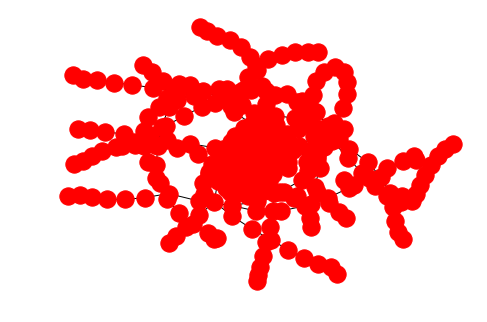

In [11]:
graph = nx.Graph()

for connection_id, connection in connections.iterrows():
    station1_name = stations.ix[connection['station1']]['name']
    station2_name = stations.ix[connection['station2']]['name']
    graph.add_edge(station1_name, station2_name, time = connection['time'])
    
#add the connection between Bank and Monument manually
graph.add_edge('Bank', 'Monument', time = 1)
nx.draw(graph)

In [12]:
nx.shortest_path(graph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Tottenham Court Road',
 'Holborn',
 'Chancery Lane',
 "St. Paul's",
 'Bank',
 'Shadwell',
 'Wapping',
 'Rotherhithe',
 'Canada Water',
 'Canary Wharf']

In [13]:
print(graph)

In [14]:
normed = stations[['longitude', 'latitude']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for edge in graph.edges():
    p.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
    )

for node in graph.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':node}, 
        text_font_size = str(10) +"pt",
        text_align='center',
        text_font_style='bold')
    
show(p)

In [15]:
nx.algorithms.connectivity.cuts.minimum_node_cut(graph)

{'Leytonstone'}

In [21]:
nx.algorithms.connectivity.stoerwagner.stoer_wagner(graph)

(1,
 (['Upminster'],
  ['Perivale',
   'Barking',
   'Warwick Avenue',
   'Gloucester Road',
   'Heron Quays',
   'Kentish Town',
   'Bethnal Green',
   'Kilburn',
   'Waterloo',
   'Island Gardens',
   'Baker Street',
   'Blackwall',
   "Regent's Park",
   'Grange Hill',
   'Pudding Mill Lane',
   'Mansion House',
   'Bromley-By-Bow',
   'West Harrow',
   'Tower Hill',
   'Ealing Common',
   'Kensal Green',
   'Picadilly Circus',
   'Boston Manor',
   "St. John's Wood",
   'New Cross',
   'East India',
   'Park Royal',
   'Fulham Broadway',
   'Northfields',
   'South Woodford',
   'Hainault',
   'Dagenham East',
   'Burnt Oak',
   'Russell Square',
   'Woodford',
   'Deptford Bridge',
   'High Street Kensington',
   'Hillingdon',
   'Kenton',
   'Golders Green',
   'Bounds Green',
   'Hendon Central',
   'Roding Valley',
   'Mudchute',
   'Parsons Green',
   'Bond Street',
   'Hyde Park Corner',
   'Ruislip',
   'Holloway Road',
   'Hammersmith',
   'Watford',
   'Greenford',
   'Tot

In [18]:
#math random 2 co-ordinates
latcoors = stations['latitude']
longcoors = stations['longitude']
latmean = latcoors.mean()
longmean = longcoors.mean()

meancoors = (latmean, longmean)
print(meancoors)
randcoors1 = meancoors
randcoors2 = meancoors
#calculate distances to all stations in array from co-ordinates
distances1 = []
distances2 = []
for i in range(len(stations['longitude'])):
    distance1 = math.sqrt((randcoors1 + stations['longitude'].iloc[i-1])**2
    distance2 = math.sqrt((randcoors2 + stations['longitude'].iloc[i-1])**2
    distances1.append(distance1)
    distances2.append(distance2)

station1 = distances1.argmin()
station2 = distances2.argmin()
#pick shorest for each co-ordinate
station1 = distances1.argmin()
station2 = distances2.argmin()
#calculate shortest time taken to travel between 2 the 2 stations (Djikstras)
#return this value

(51.53436589403974, -0.15316688741721854)
